In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, normalize




Clustering Functions

In [8]:
def number_clusters(df,cluster_model):
    metrics=['silhouette','distortion','calinski_harabasz']
    model=cluster_model
    for score in metrics:
        plt.figure()
        plt.ylabel(score)
        plt.xlabel('Number of clusters')
        Visualizer=KElbowVisualizer(model,metric=score).fit(df)
        plt.show

In [9]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [10]:
def gmm_config(data,limit_nrcomponents):
    bic_values =[]
    aic_values =[]
    types_covariance=['full','diag','spherical']
    for i in types_covariance:
        n_components = np.arange(1, limit_nrcomponents)
        models = [GaussianMixture(n, covariance_type=i, n_init=10, random_state=1).fit(data)
                  for n in n_components]
        bic_values.append([m.bic(data) for m in models])
        aic_values.append([m.aic(data) for m in models])
    #barplot for BIC
    bic=plt.figure(1)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, bic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, bic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, bic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('BIC')
    plt.legend(loc='best')
   #barplot for AIC
    aic=plt.figure(2)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, aic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, aic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, aic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('AIC')
    plt.legend(loc='best')
    bic.show
    aic.show

In [11]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [12]:
#on 'type_covariance'-you have to insert with '', for example 'full'
def gmm_components(data,type_covariance,min_components,max_components):
    # Selecting number of components based on AIC and BIC
    n_components = np.arange(min_components,max_components)
    models = [GaussianMixture(n, covariance_type=type_covariance, n_init=10, random_state=1).fit(data)
              for n in n_components]

    bic_values = [m.bic(data) for m in models]
    aic_values = [m.aic(data) for m in models]
    plt.plot(n_components, bic_values, label='BIC')
    plt.plot(n_components, aic_values, label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.xticks(n_components)
    plt.show()

# DataSet for clustering by value

In [16]:
df = pd.read_csv(r'C:\Users\classroom\OneDrive - NOVAIMS\BCWDS\BC5\values_units.csv', usecols=['ProductName_ID','Point-of-Sale_ID','Value'])

In [140]:
table = pd.pivot_table(df, values='Value', index=['Point-of-Sale_ID'],
                    columns=['ProductName_ID'], aggfunc=np.sum)
table

ProductName_ID,1,2,3,4,5,6,7,8,9,10,...,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,20760.0,29690.0,45700.0,NaN,NaN,NaN,NaN,...,1447028.0,NaN,NaN,NaN,914584.00,2.506836e+06,8.589670e+06,47352.0,61767.0,44804.0
2,NaN,NaN,1740.0,17832.0,3380.0,44100.0,NaN,NaN,NaN,NaN,...,665941.0,NaN,NaN,NaN,261659.00,5.054490e+05,1.562870e+07,118112.0,46383.0,2197.0
3,NaN,3242.0,1792.0,6976.0,4971.0,7363.0,NaN,NaN,39878.0,NaN,...,686388.0,NaN,NaN,NaN,899528.00,1.144853e+06,2.169964e+07,381725.0,NaN,94903.0
4,NaN,14975.0,33272.0,101293.0,20340.0,307052.0,1650.0,3000.0,37080.0,NaN,...,2642918.0,NaN,NaN,638.0,1616587.00,2.944077e+06,3.432967e+07,165136.0,41488.0,64577.0
5,NaN,NaN,4905.0,NaN,NaN,8990.0,NaN,2750.0,19600.0,NaN,...,948720.0,NaN,NaN,NaN,688120.00,9.914450e+05,1.688569e+07,57156.0,66702.0,19773.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,NaN,NaN,NaN,NaN,NaN,13866.0,NaN,NaN,NaN,NaN,...,87947.0,NaN,NaN,NaN,392930.00,3.621490e+05,2.071944e+07,NaN,3310.0,108085.0
407,NaN,NaN,NaN,4814.0,NaN,20796.0,NaN,NaN,NaN,NaN,...,296526.0,NaN,NaN,NaN,1585422.75,1.370353e+06,4.253559e+07,NaN,1655.0,37997.0
408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1929917.0,NaN,NaN,NaN,533549.00,8.587820e+05,3.509062e+07,NaN,NaN,NaN


In [18]:
table.dtypes.value_counts()

float64    2820
dtype: int64

In [143]:
table = table.fillna(0)
table

ProductName_ID,1,2,3,4,5,6,7,8,9,10,...,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,20760.0,29690.0,45700.0,0.0,0.0,0.0,0.0,...,1447028.0,0.0,0.0,0.0,914584.00,2.506836e+06,8.589670e+06,47352.0,61767.0,44804.0
2,0.0,0.0,1740.0,17832.0,3380.0,44100.0,0.0,0.0,0.0,0.0,...,665941.0,0.0,0.0,0.0,261659.00,5.054490e+05,1.562870e+07,118112.0,46383.0,2197.0
3,0.0,3242.0,1792.0,6976.0,4971.0,7363.0,0.0,0.0,39878.0,0.0,...,686388.0,0.0,0.0,0.0,899528.00,1.144853e+06,2.169964e+07,381725.0,0.0,94903.0
4,0.0,14975.0,33272.0,101293.0,20340.0,307052.0,1650.0,3000.0,37080.0,0.0,...,2642918.0,0.0,0.0,638.0,1616587.00,2.944077e+06,3.432967e+07,165136.0,41488.0,64577.0
5,0.0,0.0,4905.0,0.0,0.0,8990.0,0.0,2750.0,19600.0,0.0,...,948720.0,0.0,0.0,0.0,688120.00,9.914450e+05,1.688569e+07,57156.0,66702.0,19773.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.0,0.0,0.0,0.0,0.0,13866.0,0.0,0.0,0.0,0.0,...,87947.0,0.0,0.0,0.0,392930.00,3.621490e+05,2.071944e+07,0.0,3310.0,108085.0
407,0.0,0.0,0.0,4814.0,0.0,20796.0,0.0,0.0,0.0,0.0,...,296526.0,0.0,0.0,0.0,1585422.75,1.370353e+06,4.253559e+07,0.0,1655.0,37997.0
408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1929917.0,0.0,0.0,0.0,533549.00,8.587820e+05,3.509062e+07,0.0,0.0,0.0


In [144]:
#Normalize
names = table.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(table)
scaled_df = pd.DataFrame(scaled_df, columns=names)
  
# Normalizing the Data 
normalized_data = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_data = pd.DataFrame(normalized_data,columns=names) 

# DataSet for clustering by product preference

In [220]:
df2 = pd.read_csv(r'C:\Users\classroom\OneDrive - NOVAIMS\BCWDS\BC5\values_units.csv', usecols=['ProductName_ID','Point-of-Sale_ID','Units'])
df2

,ProductName_ID,Point-of-Sale_ID,Units
0,649,1,2.0
1,649,1,4.0
2,649,1,2.0
3,649,1,2.0
4,649,1,2.0
...,...,...,...
91171147,577,410,1.0
91171148,577,410,1.0
91171149,577,410,1.0
91171150,577,410,1.0


In [315]:
table2 = pd.pivot_table(df2, values='Units', index=['Point-of-Sale_ID'],
                    columns=['ProductName_ID'], aggfunc=np.sum)
table2

ProductName_ID,1,2,3,4,5,6,7,8,9,10,...,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,12.0,17.0,20.0,NaN,NaN,NaN,NaN,...,785.0,NaN,NaN,NaN,1039.0,1530.0,1782.0,30.0,37.0,20.0
2,NaN,NaN,1.0,10.0,2.0,19.0,NaN,NaN,NaN,NaN,...,508.0,NaN,NaN,NaN,297.0,345.0,3274.0,77.0,28.0,1.0
3,NaN,1.0,1.0,4.0,3.0,3.0,NaN,NaN,4.0,NaN,...,531.0,NaN,NaN,NaN,1021.0,759.0,4553.0,269.0,NaN,43.0
4,NaN,5.0,20.0,57.0,13.0,145.0,1.0,1.0,4.0,NaN,...,1770.0,NaN,NaN,1.0,1835.0,1903.0,7163.0,112.0,25.0,29.0
5,NaN,NaN,3.0,NaN,NaN,4.0,NaN,1.0,2.0,NaN,...,734.0,NaN,NaN,NaN,781.0,643.0,3533.0,42.0,40.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,...,43.0,NaN,NaN,NaN,446.0,210.0,4338.0,NaN,2.0,49.0
407,NaN,NaN,NaN,2.0,NaN,11.0,NaN,NaN,NaN,NaN,...,159.0,NaN,NaN,NaN,1800.0,784.0,8886.0,NaN,1.0,17.0
408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1153.0,NaN,NaN,NaN,606.0,477.0,7378.0,NaN,NaN,NaN


In [316]:
table2 = table2.fillna(0)
table2

ProductName_ID,1,2,3,4,5,6,7,8,9,10,...,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,12.0,17.0,20.0,0.0,0.0,0.0,0.0,...,785.0,0.0,0.0,0.0,1039.0,1530.0,1782.0,30.0,37.0,20.0
2,0.0,0.0,1.0,10.0,2.0,19.0,0.0,0.0,0.0,0.0,...,508.0,0.0,0.0,0.0,297.0,345.0,3274.0,77.0,28.0,1.0
3,0.0,1.0,1.0,4.0,3.0,3.0,0.0,0.0,4.0,0.0,...,531.0,0.0,0.0,0.0,1021.0,759.0,4553.0,269.0,0.0,43.0
4,0.0,5.0,20.0,57.0,13.0,145.0,1.0,1.0,4.0,0.0,...,1770.0,0.0,0.0,1.0,1835.0,1903.0,7163.0,112.0,25.0,29.0
5,0.0,0.0,3.0,0.0,0.0,4.0,0.0,1.0,2.0,0.0,...,734.0,0.0,0.0,0.0,781.0,643.0,3533.0,42.0,40.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,43.0,0.0,0.0,0.0,446.0,210.0,4338.0,0.0,2.0,49.0
407,0.0,0.0,0.0,2.0,0.0,11.0,0.0,0.0,0.0,0.0,...,159.0,0.0,0.0,0.0,1800.0,784.0,8886.0,0.0,1.0,17.0
408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1153.0,0.0,0.0,0.0,606.0,477.0,7378.0,0.0,0.0,0.0


In [225]:
#Normalize
names = table2.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(table2)
scaled_df = pd.DataFrame(scaled_df, columns=names)
  
# Normalizing the Data 
normalized_data2 = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_data2 = pd.DataFrame(normalized_data2,columns=names) 

# Clustering for value

KMeans

 K-Elbow plots

C:\Users\classroom\Anaconda3\envs\DM\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\classroom\Anaconda3\envs\DM\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\classroom\Anaconda3\envs\DM\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\classroom\Anaconda3\envs\DM\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed e

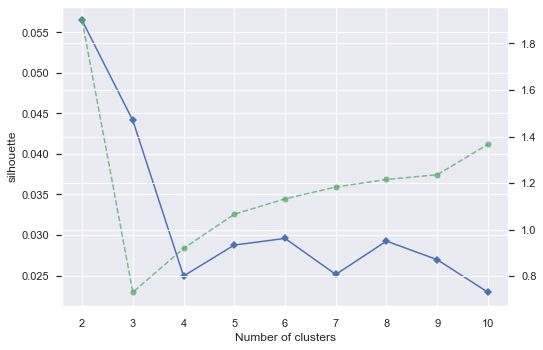

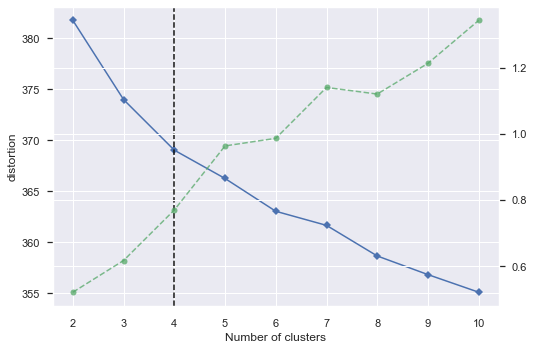

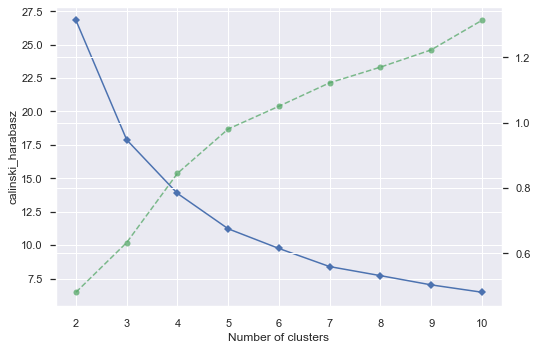

In [145]:
number_clusters(normalized_data ,KMeans( init='k-means++', n_init=15, random_state=1))

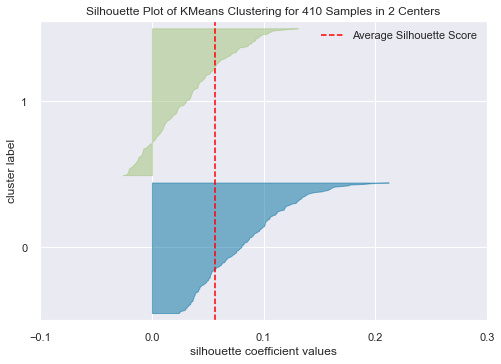

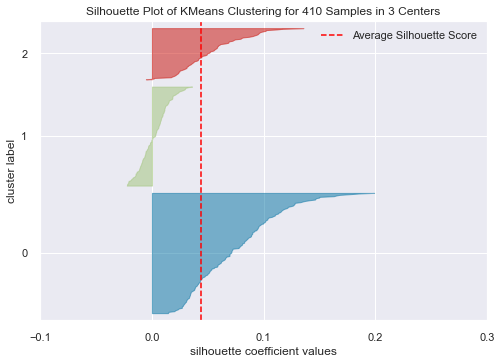

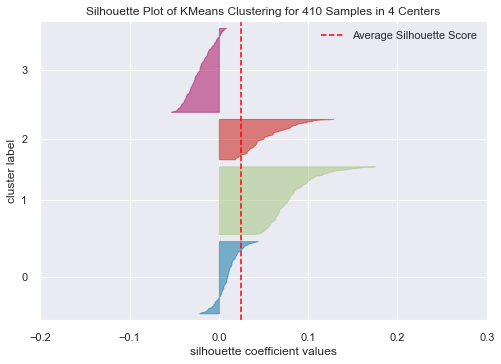

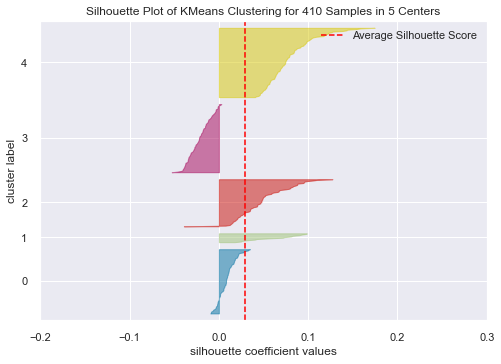

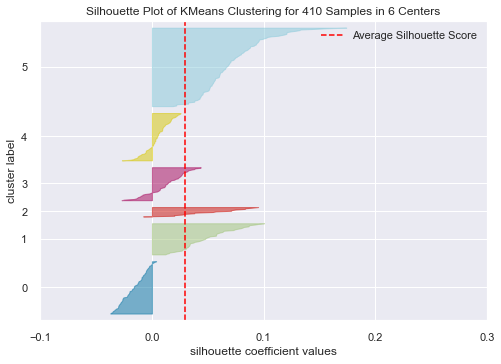

[<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>]

In [146]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(normalized_data).show() for i in range(2,7)]

In [147]:
#According to the KElbowVisualizer and the SilhouetteVisualizer we were able to determine that the optimal number of clusters is 4.
#confirmar nº de k
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(normalized_data)
df_concat = pd.concat((normalized_data, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,1,2,3,4,5,6,7,8,9,10,...,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850
labels,,,,,,,,,,,,,,,,,,,,,
0,0.001791,-0.000677,0.000952,0.006083,0.005788,0.006376,-0.000146,0.000970,-0.001161,0.000302,...,0.008399,-0.000949,-0.000949,-0.000521,0.011581,0.011130,0.013958,0.006695,0.006896,0.004808
1,-0.002019,-0.011419,-0.011694,-0.010816,-0.014801,-0.017458,-0.010383,-0.010286,-0.009170,-0.002493,...,-0.014932,0.002908,-0.001472,-0.004822,-0.022477,-0.024491,-0.018991,-0.011655,-0.009466,-0.007331
2,-0.000624,0.016180,0.011469,0.004470,0.008626,0.008776,0.009190,0.009182,0.011825,0.002006,...,0.002618,-0.000744,-0.000744,0.004422,0.010390,0.011905,-0.006236,0.003076,0.000627,0.003266
3,-0.000811,-0.007430,-0.003642,-0.003955,-0.005251,-0.004472,-0.001375,-0.003498,-0.004733,-0.001961,...,-0.003416,-0.001158,0.002060,-0.001352,-0.008253,-0.007583,-0.001736,-0.003376,-0.002528,-0.003985


In [148]:
#Making a copy of the dataset and appending a column with the cluster assigned to the observation.
km_df = normalized_data.copy()
km_df["km_labels"] = km_labels
km_df

ProductName_ID,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,km_labels
0,-0.001189,-0.008031,-0.009417,-0.006338,0.016117,-0.006199,-0.006441,-0.007045,-0.006437,-0.001386,...,-0.000818,-0.000818,-0.005321,0.001507,0.011357,-0.011922,-0.002829,0.006011,0.001728,0
1,-0.002066,-0.013952,-0.015590,-0.012567,-0.017511,-0.011335,-0.011189,-0.012239,-0.011183,-0.002408,...,-0.001422,-0.001422,-0.009243,-0.029515,-0.030589,-0.001053,0.015280,0.002109,-0.019725,3
2,-0.001288,-0.006399,-0.009709,-0.011435,-0.009205,-0.015164,-0.006978,-0.007633,-0.003961,-0.001502,...,-0.000887,-0.000887,-0.005765,0.001170,-0.009051,0.009918,0.056449,-0.014353,0.018537,0
3,-0.001013,0.001517,-0.000816,0.015581,0.005797,0.039990,0.002124,0.000658,-0.003280,-0.001180,...,-0.000697,-0.000697,-0.001385,0.018220,0.015061,0.025088,0.014070,-0.000266,0.006642,0
4,-0.001552,-0.010482,-0.010664,-0.016561,-0.017550,-0.017837,-0.008407,0.000158,-0.006618,-0.001809,...,-0.001068,-0.001068,-0.006945,-0.006407,-0.013802,0.001847,-0.001590,0.009854,-0.007777,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,-0.001701,-0.011488,-0.013470,-0.018149,-0.019232,-0.018129,-0.009213,-0.010077,-0.009208,-0.001982,...,-0.001171,-0.001171,-0.007611,-0.018983,-0.028153,0.010840,-0.015174,-0.017473,0.030263,3
406,-0.001131,-0.007636,-0.008953,-0.010664,-0.012784,-0.010710,-0.006124,-0.006698,-0.006120,-0.001318,...,-0.000778,-0.000778,-0.005059,0.019501,-0.004840,0.040551,-0.010086,-0.012105,-0.000345,0
407,-0.001415,-0.009554,-0.011202,-0.015094,-0.015995,-0.018432,-0.007662,-0.008381,-0.007658,-0.001649,...,-0.000974,-0.000974,-0.006330,-0.011049,-0.014864,0.036500,-0.012620,-0.015760,-0.014310,3
408,-0.001243,-0.008392,-0.009840,-0.013258,-0.014050,-0.016190,-0.006730,-0.007362,-0.006726,-0.001448,...,-0.000855,-0.000855,-0.005560,-0.000463,-0.010961,-0.004043,-0.011085,-0.013843,-0.012569,3


GMM

Choosing the type of covariance

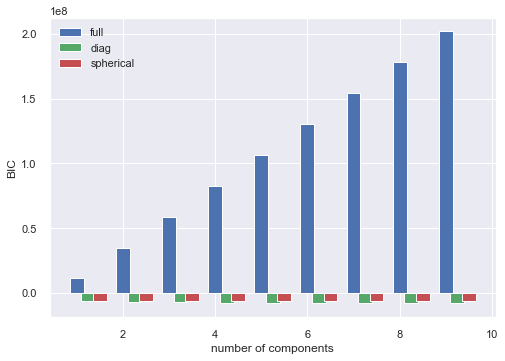

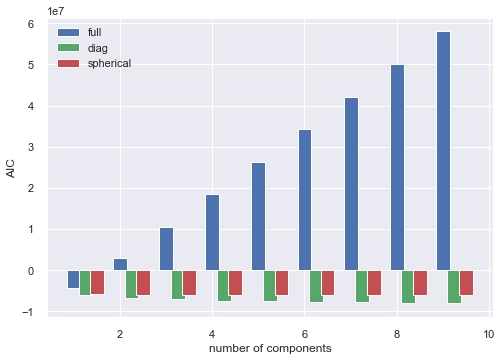

In [34]:
gmm_config(normalized_data,10)

For the most part, the number of components the model with the lowest AIC and BIC is 'diag' 


Find the number of components

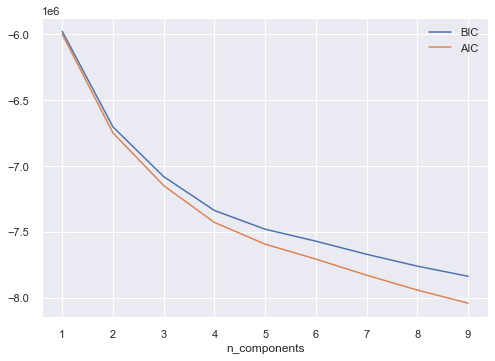

In [35]:
gmm_components(normalized_data,'diag',1,10)

According to the graph, the teams considers the optimal number of components is 4.

Applying the clustering

In [36]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='diag', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(normalized_data)
# Concatenating the labels to df
df_concat = pd.concat([normalized_data, pd.Series(gmm_labels, index=normalized_data.index, name="gmm_labels")], axis=1)
df_concat.head()

,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,gmm_labels
0,-0.001189,-0.008031,-0.009417,-0.006338,0.016117,-0.006199,-0.006441,-0.007045,-0.006437,-0.001386,...,-0.000818,-0.000818,-0.005321,0.001507,0.011357,-0.011922,-0.002829,0.006011,0.001728,0
1,-0.002066,-0.013952,-0.015590,-0.012567,-0.017511,-0.011335,-0.011189,-0.012239,-0.011183,-0.002408,...,-0.001422,-0.001422,-0.009243,-0.029515,-0.030589,-0.001053,0.015280,0.002109,-0.019725,2
2,-0.001288,-0.006399,-0.009709,-0.011435,-0.009205,-0.015164,-0.006978,-0.007633,-0.003961,-0.001502,...,-0.000887,-0.000887,-0.005765,0.001170,-0.009051,0.009918,0.056449,-0.014353,0.018537,0
3,-0.001013,0.001517,-0.000816,0.015581,0.005797,0.039990,0.002124,0.000658,-0.003280,-0.001180,...,-0.000697,-0.000697,-0.001385,0.018220,0.015061,0.025088,0.014070,-0.000266,0.006642,0
4,-0.001552,-0.010482,-0.010664,-0.016561,-0.017550,-0.017837,-0.008407,0.000158,-0.006618,-0.001809,...,-0.001068,-0.001068,-0.006945,-0.006407,-0.013802,0.001847,-0.001590,0.009854,-0.007777,0


In [37]:
gmm_ = normalized_data.copy()
gmm_["gmm_labels"] = gmm_labels
gmm_

ProductName_ID,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,gmm_labels
0,-0.001189,-0.008031,-0.009417,-0.006338,0.016117,-0.006199,-0.006441,-0.007045,-0.006437,-0.001386,...,-0.000818,-0.000818,-0.005321,0.001507,0.011357,-0.011922,-0.002829,0.006011,0.001728,0
1,-0.002066,-0.013952,-0.015590,-0.012567,-0.017511,-0.011335,-0.011189,-0.012239,-0.011183,-0.002408,...,-0.001422,-0.001422,-0.009243,-0.029515,-0.030589,-0.001053,0.015280,0.002109,-0.019725,2
2,-0.001288,-0.006399,-0.009709,-0.011435,-0.009205,-0.015164,-0.006978,-0.007633,-0.003961,-0.001502,...,-0.000887,-0.000887,-0.005765,0.001170,-0.009051,0.009918,0.056449,-0.014353,0.018537,0
3,-0.001013,0.001517,-0.000816,0.015581,0.005797,0.039990,0.002124,0.000658,-0.003280,-0.001180,...,-0.000697,-0.000697,-0.001385,0.018220,0.015061,0.025088,0.014070,-0.000266,0.006642,0
4,-0.001552,-0.010482,-0.010664,-0.016561,-0.017550,-0.017837,-0.008407,0.000158,-0.006618,-0.001809,...,-0.001068,-0.001068,-0.006945,-0.006407,-0.013802,0.001847,-0.001590,0.009854,-0.007777,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,-0.001701,-0.011488,-0.013470,-0.018149,-0.019232,-0.018129,-0.009213,-0.010077,-0.009208,-0.001982,...,-0.001171,-0.001171,-0.007611,-0.018983,-0.028153,0.010840,-0.015174,-0.017473,0.030263,3
406,-0.001131,-0.007636,-0.008953,-0.010664,-0.012784,-0.010710,-0.006124,-0.006698,-0.006120,-0.001318,...,-0.000778,-0.000778,-0.005059,0.019501,-0.004840,0.040551,-0.010086,-0.012105,-0.000345,3
407,-0.001415,-0.009554,-0.011202,-0.015094,-0.015995,-0.018432,-0.007662,-0.008381,-0.007658,-0.001649,...,-0.000974,-0.000974,-0.006330,-0.011049,-0.014864,0.036500,-0.012620,-0.015760,-0.014310,3
408,-0.001243,-0.008392,-0.009840,-0.013258,-0.014050,-0.016190,-0.006730,-0.007362,-0.006726,-0.001448,...,-0.000855,-0.000855,-0.005560,-0.000463,-0.010961,-0.004043,-0.011085,-0.013843,-0.012569,3


# Hierarquical Clustering

In [21]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(normalized_data)
hc_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 0, 2, 2,
       2, 2, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 0,
       1, 2, 0, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 0, 1, 3, 0, 1, 1, 0, 0, 0, 2, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 0, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3,
       3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 2, 3, 2, 2, 2,
       3, 2, 2, 0, 2, 2, 2, 0, 0, 3, 3, 0, 3, 2, 0,

In [22]:
# Computing SST
X = normalized_data.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True, ...,  True,  True,  True])

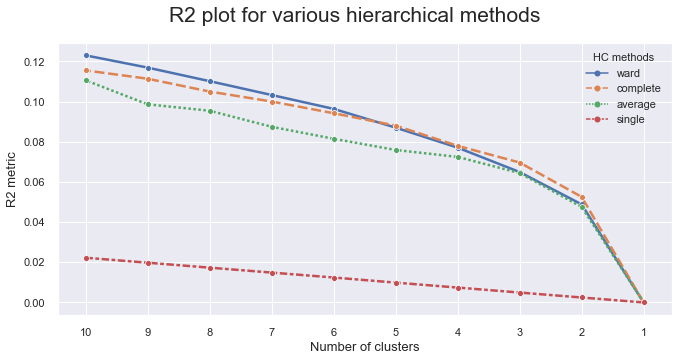

In [23]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=normalized_data, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [24]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(normalized_data)

array([321, 257, 276, 269, 309, 331, 355, 307, 302, 349, 301, 238, 150,
       267, 273, 296, 264, 285, 252, 348, 230, 352, 258, 397, 310, 262,
       212, 334, 219, 282, 327, 364, 251, 291, 343, 227, 218, 384, 312,
       236, 401, 288, 259, 371, 293, 357, 332, 376, 358, 392, 320, 277,
       272, 255, 353, 261, 313, 375, 205, 211, 221, 281, 286, 407, 298,
       154, 315, 367, 231, 361, 235, 382, 268, 359, 344, 217, 335, 373,
       215, 210, 396, 377, 300, 339, 297, 165, 337, 241, 283, 278, 294,
       245, 399, 260, 140, 247, 389, 133, 208, 209, 108, 223, 280, 270,
       391, 146, 237, 374, 222, 369, 117, 274, 299, 329, 350, 372, 284,
       295, 287, 381, 370, 314, 263, 360, 244, 246, 243, 228, 271, 125,
       292, 141, 303, 305, 351, 409, 253, 206, 225, 142, 368, 356, 345,
       328, 325, 242, 226, 175, 163, 308, 265, 395, 248, 330, 354, 149,
       385, 110, 134, 279, 185, 220, 254,  66, 324, 383, 204, 113, 229,
       129, 130, 216, 184, 405, 378, 174, 318, 304, 250, 393, 19

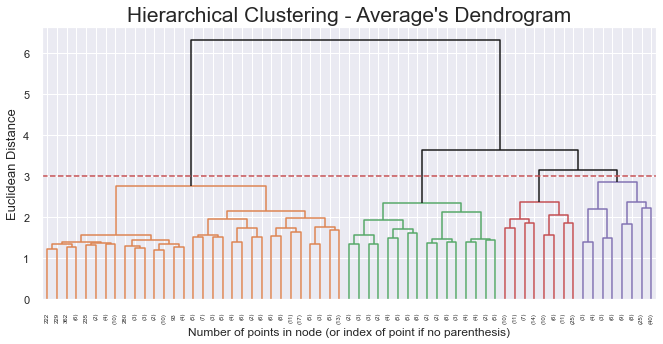

In [123]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 3
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [131]:
# 3 cluster solution
linkage = 'average'
distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc3_labels = hc3lust.fit_predict(normalized_data)

In [132]:
# Characterizing the 3 clusters
HC= pd.concat((normalized_data, pd.Series(hc3_labels, name='labels')), axis=1)
HC.groupby('labels').mean()

,1,2,3,4,5,6,7,8,9,10,...,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850
labels,,,,,,,,,,,,,,,,,,,,,
0,-0.001692,-0.009623,-0.002333,-0.004025,-0.001614,-0.005706,-0.002115,-0.000391,-0.004190,0.008213,...,-0.004135,-0.001164,-0.001164,-0.005959,0.009359,0.008025,0.003546,-0.006092,0.011996,0.006541
1,-0.000304,-0.002150,-0.002544,0.001158,0.002294,0.002903,-0.004210,0.001115,-0.002491,-0.001760,...,0.006150,-0.001039,-0.001039,0.001336,0.002151,0.006149,0.009550,0.000732,0.001475,0.000135
2,0.002660,0.009128,0.010209,0.006880,0.008106,0.009614,0.006970,0.005240,0.006852,0.000684,...,0.006631,-0.000811,-0.000811,0.003149,0.011783,0.009776,0.002138,0.009960,0.003128,0.004399
3,-0.001836,-0.008872,-0.008231,-0.007176,-0.010448,-0.011599,-0.004939,-0.007530,-0.006801,-0.002215,...,-0.010567,0.001051,0.000837,-0.003985,-0.015684,-0.016846,-0.011463,-0.008492,-0.006226,-0.005813


In [133]:
HC

,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,labels
0,-0.001189,-0.008031,-0.009417,-0.006338,0.016117,-0.006199,-0.006441,-0.007045,-0.006437,-0.001386,...,-0.000818,-0.000818,-0.005321,0.001507,0.011357,-0.011922,-0.002829,0.006011,0.001728,1
1,-0.002066,-0.013952,-0.015590,-0.012567,-0.017511,-0.011335,-0.011189,-0.012239,-0.011183,-0.002408,...,-0.001422,-0.001422,-0.009243,-0.029515,-0.030589,-0.001053,0.015280,0.002109,-0.019725,1
2,-0.001288,-0.006399,-0.009709,-0.011435,-0.009205,-0.015164,-0.006978,-0.007633,-0.003961,-0.001502,...,-0.000887,-0.000887,-0.005765,0.001170,-0.009051,0.009918,0.056449,-0.014353,0.018537,1
3,-0.001013,0.001517,-0.000816,0.015581,0.005797,0.039990,0.002124,0.000658,-0.003280,-0.001180,...,-0.000697,-0.000697,-0.001385,0.018220,0.015061,0.025088,0.014070,-0.000266,0.006642,1
4,-0.001552,-0.010482,-0.010664,-0.016561,-0.017550,-0.017837,-0.008407,0.000158,-0.006618,-0.001809,...,-0.001068,-0.001068,-0.006945,-0.006407,-0.013802,0.001847,-0.001590,0.009854,-0.007777,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,-0.001701,-0.011488,-0.013470,-0.018149,-0.019232,-0.018129,-0.009213,-0.010077,-0.009208,-0.001982,...,-0.001171,-0.001171,-0.007611,-0.018983,-0.028153,0.010840,-0.015174,-0.017473,0.030263,3
406,-0.001131,-0.007636,-0.008953,-0.010664,-0.012784,-0.010710,-0.006124,-0.006698,-0.006120,-0.001318,...,-0.000778,-0.000778,-0.005059,0.019501,-0.004840,0.040551,-0.010086,-0.012105,-0.000345,3
407,-0.001415,-0.009554,-0.011202,-0.015094,-0.015995,-0.018432,-0.007662,-0.008381,-0.007658,-0.001649,...,-0.000974,-0.000974,-0.006330,-0.011049,-0.014864,0.036500,-0.012620,-0.015760,-0.014310,3
408,-0.001243,-0.008392,-0.009840,-0.013258,-0.014050,-0.016190,-0.006730,-0.007362,-0.006726,-0.001448,...,-0.000855,-0.000855,-0.005560,-0.000463,-0.010961,-0.004043,-0.011085,-0.013843,-0.012569,3


# Metrica para comparar clusters

In [149]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable
def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

In [150]:
print('The r2 of the k-means method is', r2(km_df, 'km_labels').round(2))
print('The r2 of the GMM method is', r2(gmm_, 'gmm_labels').round(2))
print('The r2 of the HC method is', r2(HC, 'labels').round(2))


The r2 of the k-means method is 0.63
The r2 of the GMM method is 0.57
The r2 of the HC method is 0.51


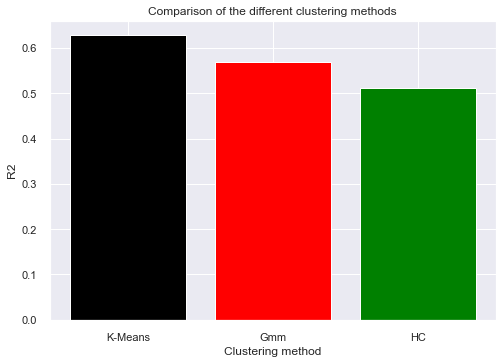

In [152]:
r2_list = [r2(km_df, 'km_labels'), r2(gmm_, 'gmm_labels'), r2(HC, 'labels')]
r2_tograph = np.asarray(r2_list)
# Create a List of Labels for x-axis
names = ["K-Means", "Gmm","HC"]
# Make the Chart
plt.bar(names, r2_tograph, color=['black', 'red', 'green'])
plt.title('Comparison of the different clustering methods')
plt.xlabel('Clustering method')
plt.ylabel('R2')
# Show the Chart
plt.show()

Due the fact that the all cluster methods have the same number of variables we can choose the best method by comparing the r^2 of each method
After analyse the previous barplot we came to the conclusion that the K-means is the best method

In [272]:
#Clusters to analyse
table = table.reset_index()
KM_final = pd.concat((table , pd.Series(km_labels, name='labels')), axis=1)
KM_final = KM_final.set_index('Point-of-Sale_ID')
KM_final

,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,labels
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,12.0,17.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1039.0,1530.0,1782.0,30.0,37.0,20.0,3
2,0.0,0.0,1.0,10.0,2.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,297.0,345.0,3274.0,77.0,28.0,1.0,0
3,0.0,1.0,1.0,4.0,3.0,3.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,1021.0,759.0,4553.0,269.0,0.0,43.0,0
4,0.0,5.0,20.0,57.0,13.0,145.0,1.0,1.0,4.0,0.0,...,0.0,0.0,1.0,1835.0,1903.0,7163.0,112.0,25.0,29.0,3
5,0.0,0.0,3.0,0.0,0.0,4.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,781.0,643.0,3533.0,42.0,40.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,446.0,210.0,4338.0,0.0,2.0,49.0,0
407,0.0,0.0,0.0,2.0,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1800.0,784.0,8886.0,0.0,1.0,17.0,3
408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,606.0,477.0,7378.0,0.0,0.0,0.0,0


Saving the clusters to analyse later

In [284]:
cluster10 = KM_final.loc[KM_final['labels'] == 0]
cluster11 = KM_final.loc[KM_final['labels'] == 1]
cluster12 = KM_final.loc[KM_final['labels'] == 2]
cluster13 = KM_final.loc[KM_final['labels'] == 3]

#check if we didn't lost any POS
len(KM_final) == len(cluster11) + len(cluster12) + len(cluster13) +len(cluster10)

True

# Clustering for product

KMeans

K-Elbow plots

C:\Users\classroom\Anaconda3\envs\DM\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\classroom\Anaconda3\envs\DM\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\classroom\Anaconda3\envs\DM\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\classroom\Anaconda3\envs\DM\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed e

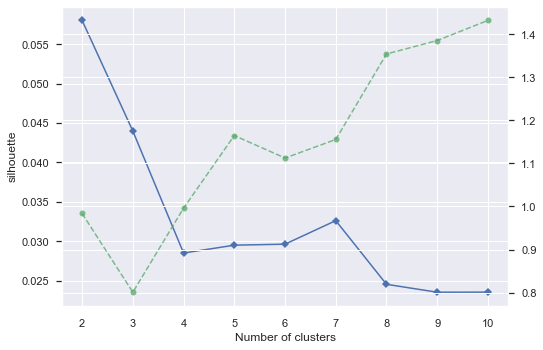

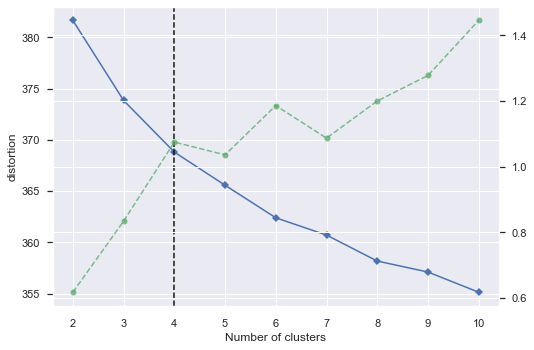

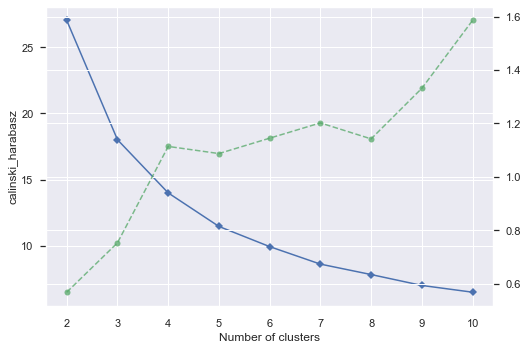

In [226]:
number_clusters(normalized_data2 ,KMeans( init='k-means++', n_init=15, random_state=1))

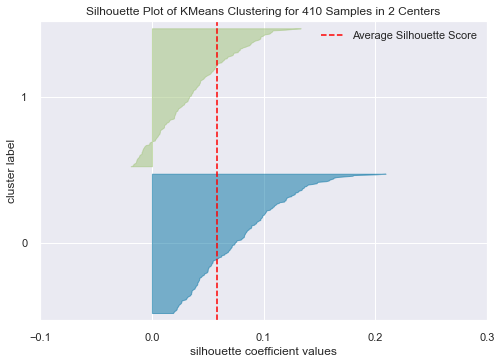

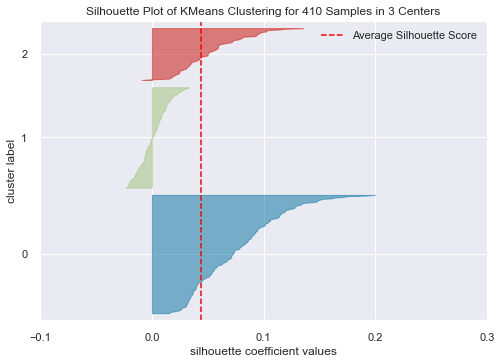

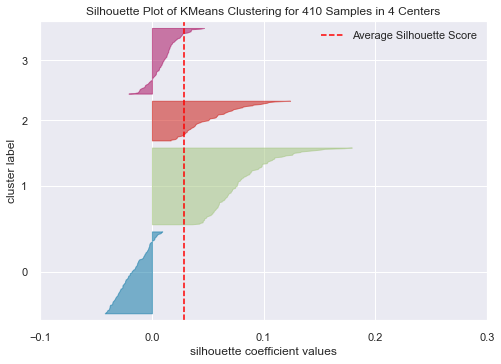

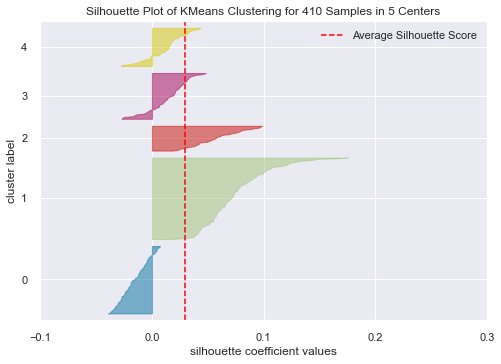

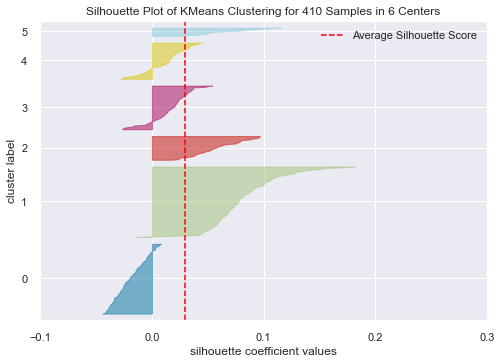

[<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
 <AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 410 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>]

In [227]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(normalized_data2).show() for i in range(2,7)]

In [229]:
#According to the KElbowVisualizer and the SilhouetteVisualizer we were able to determine that the optimal number of clusters is 4.
#confirmar nº de k
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(normalized_data2)
df_concat = pd.concat((normalized_data2, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,1,2,3,4,5,6,7,8,9,10,...,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850
labels,,,,,,,,,,,,,,,,,,,,,
0,-0.000630,-0.007160,-0.004561,-0.002292,-0.004424,-0.003069,-0.001166,-0.002854,-0.004016,-0.001813,...,-0.002200,-0.001108,-0.001108,-0.000578,-0.006378,-0.005666,-0.000096,-0.001975,-0.001076,-0.002418
1,-0.002041,-0.010446,-0.010362,-0.010415,-0.013821,-0.016112,-0.009658,-0.010053,-0.009371,-0.002385,...,-0.013415,0.002405,0.002053,-0.005272,-0.021560,-0.023098,-0.017577,-0.010700,-0.009910,-0.007468
2,-0.000666,0.016648,0.011956,0.004003,0.008129,0.007757,0.008762,0.009682,0.012347,0.001980,...,0.002019,-0.000745,-0.000745,0.003419,0.010492,0.012153,-0.006195,0.002569,0.000887,0.002582
3,0.001956,-0.000603,0.002165,0.006189,0.006725,0.007109,0.000783,0.001279,-0.000603,0.000294,...,0.008726,-0.000944,-0.000944,0.000325,0.012289,0.011456,0.014001,0.006596,0.007239,0.004855


In [230]:
#Making a copy of the dataset and appending a column with the cluster assigned to the observation.
km_df2 = normalized_data.copy()
km_df2["km_labels"] = km_labels
km_df2

ProductName_ID,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,km_labels
0,-0.001189,-0.008031,-0.009417,-0.006338,0.016117,-0.006199,-0.006441,-0.007045,-0.006437,-0.001386,...,-0.000818,-0.000818,-0.005321,0.001507,0.011357,-0.011922,-0.002829,0.006011,0.001728,3
1,-0.002066,-0.013952,-0.015590,-0.012567,-0.017511,-0.011335,-0.011189,-0.012239,-0.011183,-0.002408,...,-0.001422,-0.001422,-0.009243,-0.029515,-0.030589,-0.001053,0.015280,0.002109,-0.019725,0
2,-0.001288,-0.006399,-0.009709,-0.011435,-0.009205,-0.015164,-0.006978,-0.007633,-0.003961,-0.001502,...,-0.000887,-0.000887,-0.005765,0.001170,-0.009051,0.009918,0.056449,-0.014353,0.018537,0
3,-0.001013,0.001517,-0.000816,0.015581,0.005797,0.039990,0.002124,0.000658,-0.003280,-0.001180,...,-0.000697,-0.000697,-0.001385,0.018220,0.015061,0.025088,0.014070,-0.000266,0.006642,3
4,-0.001552,-0.010482,-0.010664,-0.016561,-0.017550,-0.017837,-0.008407,0.000158,-0.006618,-0.001809,...,-0.001068,-0.001068,-0.006945,-0.006407,-0.013802,0.001847,-0.001590,0.009854,-0.007777,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,-0.001701,-0.011488,-0.013470,-0.018149,-0.019232,-0.018129,-0.009213,-0.010077,-0.009208,-0.001982,...,-0.001171,-0.001171,-0.007611,-0.018983,-0.028153,0.010840,-0.015174,-0.017473,0.030263,0
406,-0.001131,-0.007636,-0.008953,-0.010664,-0.012784,-0.010710,-0.006124,-0.006698,-0.006120,-0.001318,...,-0.000778,-0.000778,-0.005059,0.019501,-0.004840,0.040551,-0.010086,-0.012105,-0.000345,3
407,-0.001415,-0.009554,-0.011202,-0.015094,-0.015995,-0.018432,-0.007662,-0.008381,-0.007658,-0.001649,...,-0.000974,-0.000974,-0.006330,-0.011049,-0.014864,0.036500,-0.012620,-0.015760,-0.014310,0
408,-0.001243,-0.008392,-0.009840,-0.013258,-0.014050,-0.016190,-0.006730,-0.007362,-0.006726,-0.001448,...,-0.000855,-0.000855,-0.005560,-0.000463,-0.010961,-0.004043,-0.011085,-0.013843,-0.012569,0


GMM

Choosing the type of covariance

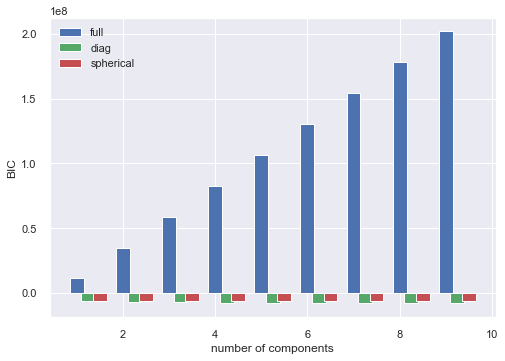

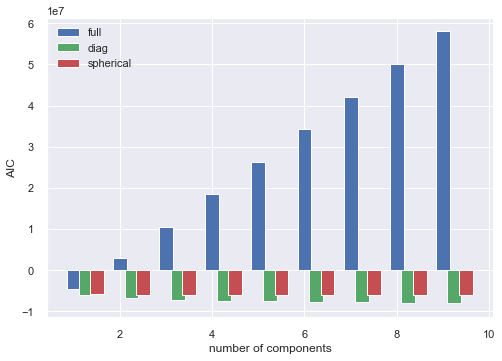

In [231]:
gmm_config(normalized_data2,10)

For the most part, the number of components the model with the lowest AIC and BIC is 'diag' 


Find the number of components

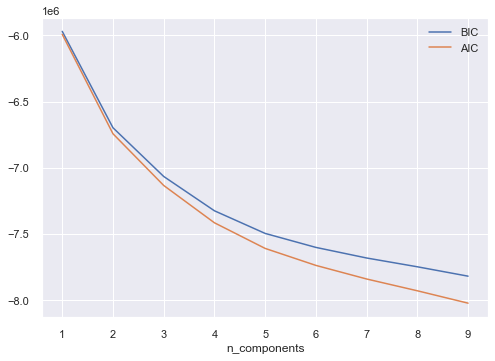

In [233]:
gmm_components(normalized_data2,'diag',1,10)

According to the graph, the teams considers the optimal number of components is 4.

Applying the clustering

In [234]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='diag', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(normalized_data)
# Concatenating the labels to df
df_concat = pd.concat([normalized_data, pd.Series(gmm_labels, index=normalized_data.index, name="gmm_labels")], axis=1)
df_concat.head()

,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,gmm_labels
0,-0.001189,-0.008031,-0.009417,-0.006338,0.016117,-0.006199,-0.006441,-0.007045,-0.006437,-0.001386,...,-0.000818,-0.000818,-0.005321,0.001507,0.011357,-0.011922,-0.002829,0.006011,0.001728,0
1,-0.002066,-0.013952,-0.015590,-0.012567,-0.017511,-0.011335,-0.011189,-0.012239,-0.011183,-0.002408,...,-0.001422,-0.001422,-0.009243,-0.029515,-0.030589,-0.001053,0.015280,0.002109,-0.019725,2
2,-0.001288,-0.006399,-0.009709,-0.011435,-0.009205,-0.015164,-0.006978,-0.007633,-0.003961,-0.001502,...,-0.000887,-0.000887,-0.005765,0.001170,-0.009051,0.009918,0.056449,-0.014353,0.018537,0
3,-0.001013,0.001517,-0.000816,0.015581,0.005797,0.039990,0.002124,0.000658,-0.003280,-0.001180,...,-0.000697,-0.000697,-0.001385,0.018220,0.015061,0.025088,0.014070,-0.000266,0.006642,0
4,-0.001552,-0.010482,-0.010664,-0.016561,-0.017550,-0.017837,-0.008407,0.000158,-0.006618,-0.001809,...,-0.001068,-0.001068,-0.006945,-0.006407,-0.013802,0.001847,-0.001590,0.009854,-0.007777,0


In [236]:
gmm_2= normalized_data.copy()
gmm_2["gmm_labels"] = gmm_labels
gmm_2

ProductName_ID,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,gmm_labels
0,-0.001189,-0.008031,-0.009417,-0.006338,0.016117,-0.006199,-0.006441,-0.007045,-0.006437,-0.001386,...,-0.000818,-0.000818,-0.005321,0.001507,0.011357,-0.011922,-0.002829,0.006011,0.001728,0
1,-0.002066,-0.013952,-0.015590,-0.012567,-0.017511,-0.011335,-0.011189,-0.012239,-0.011183,-0.002408,...,-0.001422,-0.001422,-0.009243,-0.029515,-0.030589,-0.001053,0.015280,0.002109,-0.019725,2
2,-0.001288,-0.006399,-0.009709,-0.011435,-0.009205,-0.015164,-0.006978,-0.007633,-0.003961,-0.001502,...,-0.000887,-0.000887,-0.005765,0.001170,-0.009051,0.009918,0.056449,-0.014353,0.018537,0
3,-0.001013,0.001517,-0.000816,0.015581,0.005797,0.039990,0.002124,0.000658,-0.003280,-0.001180,...,-0.000697,-0.000697,-0.001385,0.018220,0.015061,0.025088,0.014070,-0.000266,0.006642,0
4,-0.001552,-0.010482,-0.010664,-0.016561,-0.017550,-0.017837,-0.008407,0.000158,-0.006618,-0.001809,...,-0.001068,-0.001068,-0.006945,-0.006407,-0.013802,0.001847,-0.001590,0.009854,-0.007777,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,-0.001701,-0.011488,-0.013470,-0.018149,-0.019232,-0.018129,-0.009213,-0.010077,-0.009208,-0.001982,...,-0.001171,-0.001171,-0.007611,-0.018983,-0.028153,0.010840,-0.015174,-0.017473,0.030263,3
406,-0.001131,-0.007636,-0.008953,-0.010664,-0.012784,-0.010710,-0.006124,-0.006698,-0.006120,-0.001318,...,-0.000778,-0.000778,-0.005059,0.019501,-0.004840,0.040551,-0.010086,-0.012105,-0.000345,3
407,-0.001415,-0.009554,-0.011202,-0.015094,-0.015995,-0.018432,-0.007662,-0.008381,-0.007658,-0.001649,...,-0.000974,-0.000974,-0.006330,-0.011049,-0.014864,0.036500,-0.012620,-0.015760,-0.014310,3
408,-0.001243,-0.008392,-0.009840,-0.013258,-0.014050,-0.016190,-0.006730,-0.007362,-0.006726,-0.001448,...,-0.000855,-0.000855,-0.005560,-0.000463,-0.010961,-0.004043,-0.011085,-0.013843,-0.012569,3


# HC

In [238]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(normalized_data2)
hc_labels

array([3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 3, 1, 0, 1, 1,
       1, 1, 3, 3, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 3, 3, 1, 3, 3,
       3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 0, 3, 1, 1, 3, 3, 0, 3, 1, 3, 3, 0, 1, 1, 1, 1, 1, 1, 0,
       3, 1, 0, 1, 1, 0, 0, 2, 0, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 2, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 2, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 2, 0, 3, 3, 3, 0, 3, 0, 0,
       0, 0, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 0, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 2, 0, 0, 3, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 4, 1, 0, 4, 0, 2, 4, 4, 0, 4, 2, 0, 2, 2,
       2, 2, 4, 4, 2, 2, 2, 4, 4, 0, 4, 4, 4, 2, 2, 4, 2, 1, 4, 1, 2, 1,
       4, 1, 1, 2, 2, 1, 1, 0, 0, 2, 4, 0, 4, 2, 0,

In [239]:
# Computing SST
X = normalized_data2.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True, ...,  True,  True,  True])

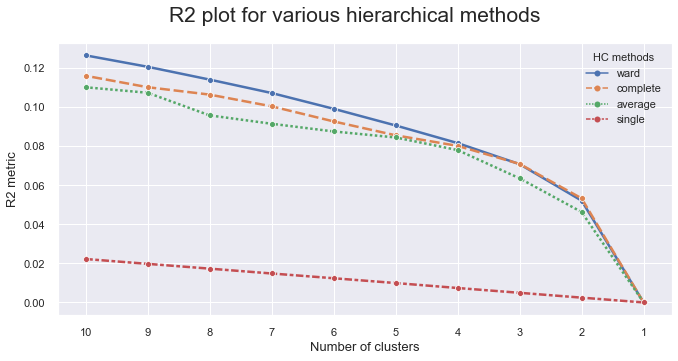

In [241]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=normalized_data2, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [242]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(normalized_data2)

array([317, 254, 379, 269, 217, 326, 207, 293, 231, 361, 335, 244, 299,
       273, 225, 319, 263, 294, 357, 336, 222, 350, 213, 328, 300, 303,
       209, 332, 377, 277, 314, 362, 291, 279, 343, 230, 375, 382, 296,
       223, 381, 289, 329, 380, 337, 331, 239, 378, 355, 392, 391, 276,
       347, 261, 245, 260, 323, 325, 285, 235, 206, 224, 282, 360, 287,
       310, 371, 409, 229, 367, 232, 189, 359, 344, 311, 214, 318, 372,
       215, 267, 397, 376, 272, 387, 286, 330, 275, 255, 407, 281, 298,
       140, 389, 246, 253, 208, 187, 280, 383, 211, 307, 270, 363, 262,
       394, 292, 241, 327, 259, 134, 216, 268, 122, 349, 348, 185, 274,
       139, 320, 365, 295, 393, 195, 364, 315, 248, 237, 236, 117, 106,
       301, 130, 147, 312, 388, 233, 247, 149, 249, 271, 369, 135, 358,
       368, 165, 240, 227, 305, 297, 309, 313, 395, 242, 190, 346, 385,
       384, 114, 398, 212, 339, 251, 304, 264, 338, 191, 204, 218, 173,
       302, 133, 234, 238, 405, 396, 356, 265,  69, 228, 126, 29

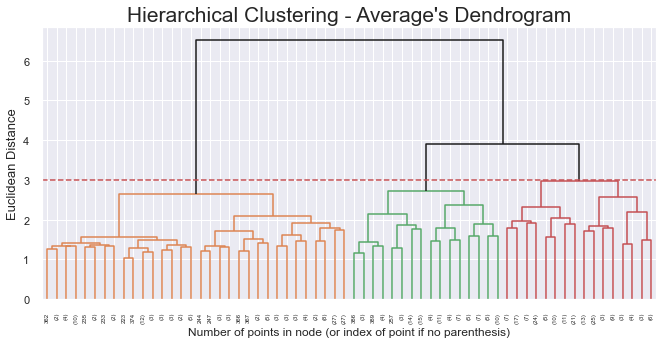

In [298]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 3
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [299]:
# 3 cluster solution
linkage = 'average'
distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=3)
hc3_labels = hc3lust.fit_predict(normalized_data2)

In [300]:
# Characterizing the 3 clusters
HC2= pd.concat((normalized_data, pd.Series(hc3_labels, name='labels')), axis=1)
HC2.groupby('labels').mean()

,1,2,3,4,5,6,7,8,9,10,...,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850
labels,,,,,,,,,,,,,,,,,,,,,
0,-0.001808,-0.009381,-0.007080,-0.005637,-0.009148,-0.010374,-0.004230,-0.007451,-0.007225,-0.001214,...,-0.008179,0.000779,0.000593,-0.003782,-0.012671,-0.014539,-0.008201,-0.006968,-0.005199,-0.003946
1,-0.000241,-0.001727,0.000347,0.001330,0.003140,0.004244,-0.004583,0.000883,-0.000599,-0.001774,...,0.005793,-0.001047,-0.001047,0.000480,0.003223,0.007617,0.009148,0.001870,0.002979,0.000501
2,0.002969,0.011388,0.007400,0.004863,0.007620,0.008336,0.007439,0.008011,0.007752,0.000929,...,0.003973,-0.000787,-0.000787,0.003687,0.011374,0.010441,-0.001084,0.007201,0.003987,0.003167


# Metrica para comparar clusters

In [301]:
print('The r2 of the k-means method is', r2(km_df2, 'km_labels').round(2))
print('The r2 of the GMM method is', r2(gmm_2, 'gmm_labels').round(2))
print('The r2 of the HC method is', r2(HC2, 'labels').round(2))


The r2 of the k-means method is 0.61
The r2 of the GMM method is 0.57
The r2 of the HC method is 0.44


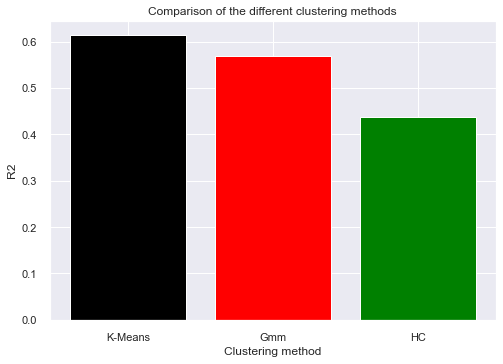

In [302]:
r_list = [r2(km_df2, 'km_labels'), r2(gmm_2, 'gmm_labels'), r2(HC2, 'labels')]
r_tograph = np.asarray(r_list)
# Create a List of Labels for x-axis
names = ["K-Means", "Gmm","HC"]
# Make the Chart
plt.bar(names, r_tograph, color=['black', 'red', 'green'])
plt.title('Comparison of the different clustering methods')
plt.xlabel('Clustering method')
plt.ylabel('R2')
# Show the Chart
plt.show()

Due the fact that the all cluster methods have the same number of variables we can choose the best method by comparing the r^2 of each method After analyse the previous barplot we came to the conclusion that the K-Means is the best method

In [317]:
#Clusters to analyse
table2 = table2.reset_index()
KMEans2_final = pd.concat((table2 , pd.Series(km_labels, name='labels')), axis=1)
KMEans2_final = KMEans2_final.set_index('Point-of-Sale_ID')
KMEans2_final

,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,labels
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,12.0,17.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1039.0,1530.0,1782.0,30.0,37.0,20.0,3
2,0.0,0.0,1.0,10.0,2.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,297.0,345.0,3274.0,77.0,28.0,1.0,0
3,0.0,1.0,1.0,4.0,3.0,3.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,1021.0,759.0,4553.0,269.0,0.0,43.0,0
4,0.0,5.0,20.0,57.0,13.0,145.0,1.0,1.0,4.0,0.0,...,0.0,0.0,1.0,1835.0,1903.0,7163.0,112.0,25.0,29.0,3
5,0.0,0.0,3.0,0.0,0.0,4.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,781.0,643.0,3533.0,42.0,40.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,446.0,210.0,4338.0,0.0,2.0,49.0,0
407,0.0,0.0,0.0,2.0,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1800.0,784.0,8886.0,0.0,1.0,17.0,3
408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,606.0,477.0,7378.0,0.0,0.0,0.0,0


In [330]:
cluster20 = KMEans2_final.loc[KMEans2_final['labels'] == 0]
cluster21 = KMEans2_final.loc[KMEans2_final['labels'] == 1]
cluster22 = KMEans2_final.loc[KMEans2_final['labels'] == 2]
cluster23 = KMEans2_final.loc[KMEans2_final['labels'] == 3]


len(HC_final) == len(cluster20) + len(cluster21) + len(cluster22) + len(cluster23)

True

In [332]:
cluster20.to_csv('cluster20.csv', index=False)
cluster21.to_csv('cluster21.csv', index=False)
cluster22.to_csv('cluster22.csv', index=False)
cluster23.to_csv('cluster23.csv', index=False)
cluster10.to_csv('cluster10.csv', index=False)
cluster11.to_csv('cluster11.csv', index=False)
cluster12.to_csv('cluster12.csv', index=False)
cluster13.to_csv('cluster13.csv', index=False)



,1,2,3,4,5,6,7,8,9,10,...,2842,2843,2844,2845,2846,2847,2848,2849,2850,labels
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,12.0,17.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1039.0,1530.0,1782.0,30.0,37.0,20.0,3
4,0.0,5.0,20.0,57.0,13.0,145.0,1.0,1.0,4.0,0.0,...,0.0,0.0,1.0,1835.0,1903.0,7163.0,112.0,25.0,29.0,3
8,0.0,0.0,14.0,136.0,29.0,128.0,0.0,1.0,6.0,0.0,...,0.0,0.0,3.0,763.0,1934.0,3777.0,206.0,1.0,48.0,3
11,0.0,0.0,5.0,0.0,4.0,50.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,503.0,918.0,8112.0,181.0,78.0,7.0,3
16,0.0,0.0,0.0,246.0,36.0,80.0,0.0,1.0,42.0,0.0,...,0.0,0.0,0.0,1048.0,906.0,4616.0,24.0,38.0,11.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.0,0.0,60.0,28.0,12.0,87.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,812.0,646.0,3785.0,244.0,37.0,31.0,3
404,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1865.0,536.0,9513.0,1.0,0.0,20.0,3
405,0.0,0.0,0.0,26.0,6.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,799.0,381.0,7589.0,0.0,0.0,0.0,3


# Analise dos clusters


In [335]:
cluster20 = pd.read_csv(r'cluster23.csv')
cluster21 = pd.read_csv(r'cluster23.csv')
cluster22 = pd.read_csv(r'cluster23.csv')
cluster23 = pd.read_csv(r'cluster23.csv')
cluster10 = pd.read_csv(r'cluster23.csv')
cluster11 = pd.read_csv(r'cluster23.csv')
cluster12 = pd.read_csv(r'cluster23.csv')
cluster13 = pd.read_csv(r'cluster23.csv')



## Por value

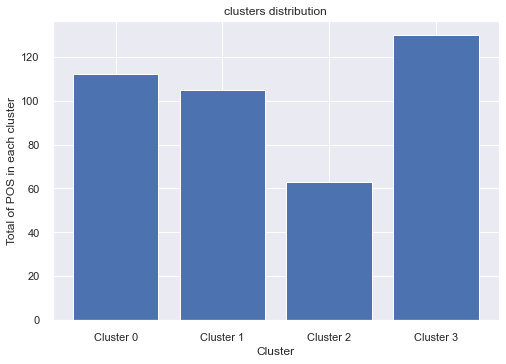

In [161]:
#clusters distribution
list1 = [len(cluster10),len(cluster11),len(cluster12),len(cluster13)]
list1 = np.asarray(list1)
# Create a List of Labels for x-axis
names = ["Cluster 0", "Cluster 1","Cluster 2", 'Cluster 3']
# Make the Chart
plt.bar(names, list1)
plt.title('clusters distribution')
plt.xlabel('Cluster')
plt.ylabel('Total of POS in each cluster')
# Show the Chart
plt.show()

In [184]:
cluster10.max().sort_values(ascending = False).head(10)

2802    1.215865e+08
1277    1.146404e+08
738     8.657668e+07
847     8.347154e+07
1956    7.490219e+07
1059    6.705815e+07
567     6.669271e+07
2847    5.900126e+07
1224    5.219843e+07
1422    5.114384e+07
dtype: float64

In [185]:
cluster11.max().sort_values(ascending = False).head(10)

1277    6.607884e+07
2802    5.946914e+07
738     5.479584e+07
1956    3.151349e+07
847     3.121828e+07
2847    2.998274e+07
2592    2.804780e+07
1059    2.440082e+07
567     2.394125e+07
728     2.149385e+07
dtype: float64

In [186]:
cluster12.max().sort_values(ascending = False).head(10)

2802    1.270732e+08
1277    1.094436e+08
738     9.027545e+07
567     8.816298e+07
1956    8.774509e+07
847     7.602672e+07
1422    4.090235e+07
2592    3.923304e+07
1278    3.918509e+07
1408    3.702186e+07
dtype: float64

In [187]:
cluster13.max().sort_values(ascending = False).head(10)

2802    1.111840e+08
738     7.416186e+07
1277    6.878809e+07
847     6.670312e+07
1224    5.613575e+07
1956    5.487639e+07
1059    5.250786e+07
2847    4.469929e+07
567     3.767917e+07
2592    2.743020e+07
dtype: float64

In [202]:
cluster10.T.sum().min()

764773964.402358

In [206]:
cluster10.T.sum().max()

1946545686.4398947

In [207]:
cluster10.T.sum()

Point-of-Sale_ID
1      9.786703e+08
3      1.048120e+09
4      1.261300e+09
8      1.196780e+09
11     9.462857e+08
           ...     
394    9.222166e+08
404    1.416623e+09
405    1.134115e+09
407    1.264067e+09
410    1.362467e+09
Length: 112, dtype: float64

In [203]:
cluster11.T.sum().min()

147502336.0

In [204]:
cluster12.T.sum().min()

327180285.26426893

In [205]:
cluster13.T.sum().min()

431841697.705882

## Por product preference

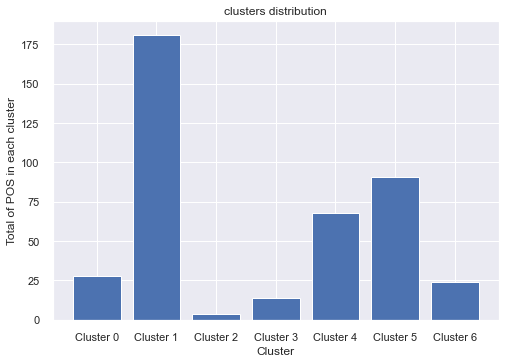

In [297]:
#clusters distribution
list1 = [len(cluster20), len(cluster21), len(cluster22) ,len(cluster23) ,len(cluster24) ,len(cluster25) ,len(cluster26)]
list1 = np.asarray(list1)
# Create a List of Labels for x-axis
names = ["Cluster 0", "Cluster 1","Cluster 2", 'Cluster 3',"Cluster 4","Cluster 5", 'Cluster 6']
# Make the Chart
plt.bar(names, list1)
plt.title('clusters distribution')
plt.xlabel('Cluster')
plt.ylabel('Total of POS in each cluster')
# Show the Chart
plt.show()